# Cognitive, behavioral and social data
**Author**: Mattia Brocco

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import support

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### Datasets at hand

In [3]:
# Organize datasets
datasets = {}
for dataset in [f for f in os.listdir(".\\data") if "parquet" in f]:
    datasets[dataset.split(".")[0]] = pd.read_parquet(f".\\data\\{dataset}")

In [15]:
def modular_pca(data, target = "CONDITION", explained_var = .7):
    
    X = data.drop(target, axis = 1).copy().values
    y = data[target].apply(lambda v: 1 if v == "HONEST" or v == "H" else 0).values
    
    center_function = lambda x: x - x.mean()
    
    X = center_function(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                        random_state = 42)
    pca = PCA(n_components = explained_var,
              svd_solver = "full")
    
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    comps = pca.components_
    
    most_important = prova = [np.c_[range(len(comps[k])),
                                    comps[k]][np.c_[range(len(comps[k])),
                                                            comps[k]][:,1].argsort()][:3,0]
                              for k in range(comps.shape[0])]

    most_important = list(set([int(subel) for el in most_important
                               for subel in el]))
    
    X_train_red = X_train[:, most_important]
    X_test_red = X_test[:, most_important]
    
    # LOGISTIC REGRESSION FULL
    full_lr = LogisticRegression(random_state = 42, solver = "saga",
                                 max_iter = 3e3, n_jobs = -1)
    full_lr.fit(X_train, y_train)
    acc_full_lr = accuracy_score(y_test, full_lr.predict(X_test))
    
    # LOGISTIC REGRESSION
    lr = LogisticRegression(random_state = 42, solver = "saga",
                            max_iter = 3e3, n_jobs = -1)
    lr.fit(X_train_red, y_train)
    acc_lr = accuracy_score(y_test, lr.predict(X_test_red))

    # RANDOM FOREST
    rf = RandomForestClassifier(random_state = 42, n_jobs = -1)
    rf.fit(X_train_red, y_train)
    acc_rf = accuracy_score(y_test, rf.predict(X_test_red))

    #SVM
    svm = SVC(random_state = 42)
    svm.fit(X_train_red, y_train)
    acc_svm = accuracy_score(y_test, svm.predict(X_test_red))

    
    perfs = [acc_full_lr, acc_lr, acc_rf, acc_svm]
    
    perfs = pd.Series(perfs, index = ["Full Logit", "Logistic Regression",
                                      "Random Forest", "SVC"])
        
    return X_train, X_test, y_train, y_test, pca, {"Features": most_important}, perfs

In [16]:
data_collection = {}
for k, v in datasets.items():
    a, b, c, d, e, f, g = modular_pca(v)
    data_collection[k] = [a, b, c, d, e, f, g]

## Assess quality of analysis
***

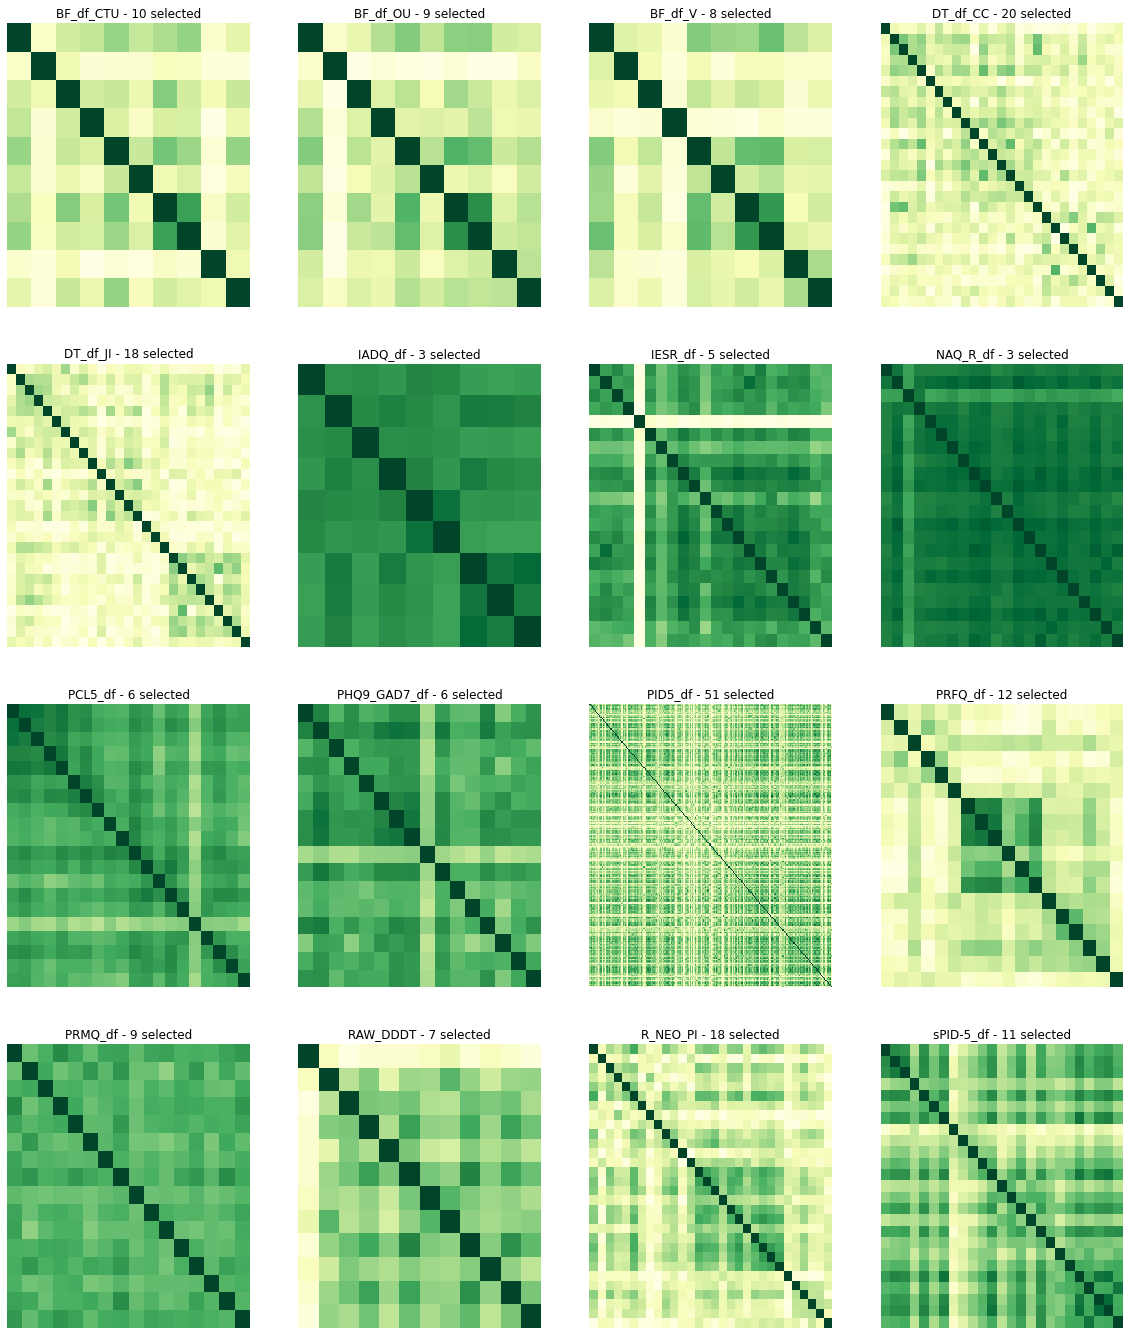

In [6]:
# Compare with correlation matrices
# The greener the higher the correlation
f0, ax0 = plt.subplots(4, 4, figsize = (20, 24))
for n, k in enumerate(data_collection.keys()):
    
    sns.heatmap(pd.DataFrame(data_collection[k][0]).corr().abs(),
                vmin = 0, vmax = 1, cmap = "YlGn",
                cbar = False, ax = ax0[n//4, n%4],
                yticklabels = False, xticklabels = False)
    ax0[n//4, n%4].set_title("{} - {} selected"\
                             .format(k, len(data_collection[k][-2]["Features"])))
plt.show()

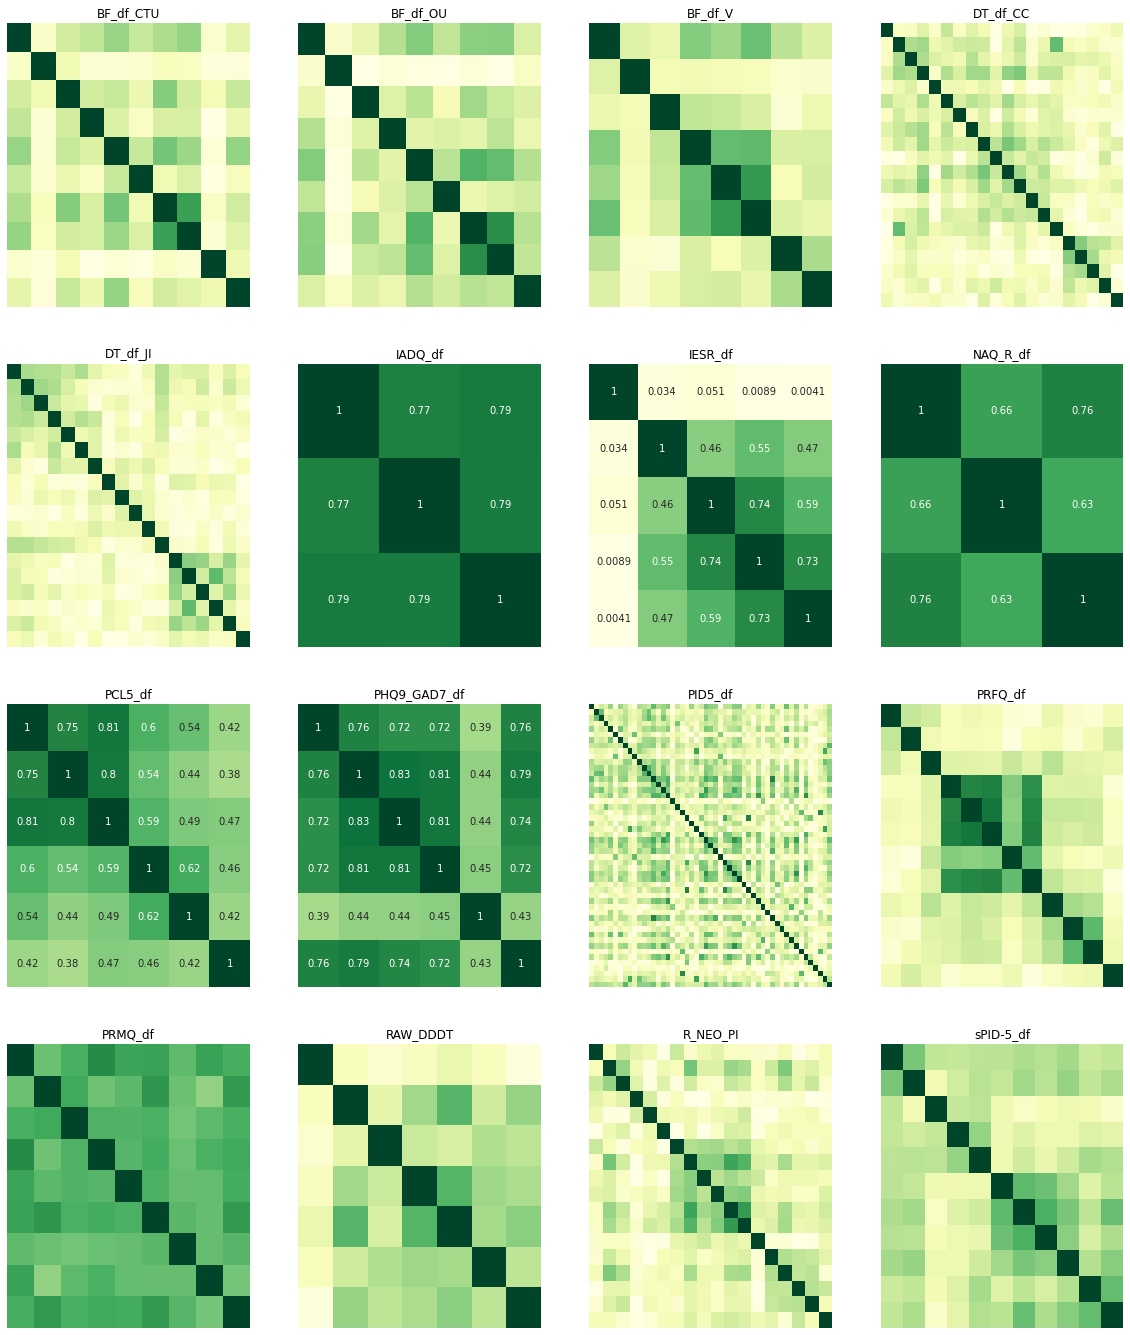

In [8]:
# Correlation matrices of only selected features
# The greener the higher the correlation
f1, ax1 = plt.subplots(4, 4, figsize = (20, 24))
for n, k in enumerate(data_collection.keys()):
    
    feats = data_collection[k][-2]["Features"]
    
    annotation = True if len(feats) < 7 else False
    
    sns.heatmap(pd.DataFrame(data_collection[k][0][:,feats]).corr().abs(),
                vmin = 0, vmax = 1, cmap = "YlGn", annot = annotation,
                cbar = False, ax = ax1[n//4, n%4],
                yticklabels = False, xticklabels = False)

    ax1[n//4, n%4].set_title(k)
    
plt.show()

In [23]:
benchmark = support.lasso_benchmark(data_collection)

In [25]:
benchmark_df = pd.DataFrame(benchmark,
                            columns = ["Dataset", "Algo", "λ min", "λ 1se",
                                       "Zero coeffs at λ min",
                                       "Delta accuracy"]).drop("Algo", axis = 1)
benchmark_df

,Dataset,λ min,λ 1se,Zero coeffs at λ min,Delta accuracy
0,BF_df_CTU,7.451,2.105,3,0.030
1,BF_df_OU,10.123,7.451,2,-0.007
2,BF_df_V,4.109,9.121,1,0.000
3,DT_df_CC,1.436,9.121,3,0.007
4,DT_df_JI,1.102,0.100,1,-0.008
5,IADQ_df,6.448,0.100,0,0.000
6,IESR_df,5.446,0.434,2,0.000
7,NAQ_R_df,21.483,21.483,0,0.000
8,PCL5_df,0.434,0.434,0,0.000
9,PHQ9_GAD7_df,20.815,0.768,1,-0.003


In [29]:
summary = []
for k, v in data_collection.items():
    
    # Dataset name
    # Sample size
    # Training size
    # Initial number of features
    # Selected features
    # ACCURACY: Full Logit
    # ACCURACY: Logistic Regression
    # ACCURACY: SVC
    # ACCURACY: Random Forest
    # ACCURACY: Neural Network
    # Average accuracy (full logit excluded)
    # Accuracy Standard deviation (full logit excluded)
    # Decreased accuracy (mean) w.r.t. full logit
    
    summary += [[k, len(v[2]) + len(v[3]), len(v[2]),
                 v[0].shape[1], len(v[-2]["Features"]),
                 *v[-1].tolist(), v[-1][1:].mean(), v[-1][1:].std(),
                 v[-1][1:].mean() - v[-1].tolist()[0]]]
    
summary = pd.DataFrame(summary,
                       columns = ["Dataset name", "Sample size", "Training size",
                                  "Number of Features", "Selected Features",
                                  "Accuracy - Logit all features", "Accuracy - Logit",
                                  "Accuracy - SVM", "Accuracy - RF", "Avg Acc. on selected features",
                                  "Accuracy Std on selected features","Acc. diff. wrt Full logit"])

summary = summary.applymap(lambda v: v if isinstance(v, str) else round(v, 3))

summary.sort_values("Accuracy Std on selected features", ascending = False)

,Dataset name,Sample size,Training size,Number of Features,Selected Features,Accuracy - Logit all features,Accuracy - Logit,Accuracy - SVM,Accuracy - RF,Avg Acc. on selected features,Accuracy Std on selected features,Acc. diff. wrt Full logit
1,BF_df_OU,460,322,10,9,0.833,0.812,0.862,0.877,0.850,0.034,0.017
0,BF_df_CTU,442,309,10,10,0.774,0.774,0.827,0.835,0.812,0.033,0.038
3,DT_df_CC,482,337,27,20,0.683,0.710,0.745,0.697,0.717,0.025,0.034
8,PCL5_df,402,281,20,6,0.785,0.777,0.777,0.818,0.791,0.024,0.006
4,DT_df_JI,864,604,27,18,0.665,0.623,0.585,0.615,0.608,0.020,-0.058
6,IESR_df,358,250,22,5,0.926,0.898,0.926,0.935,0.920,0.019,-0.006
11,PRFQ_df,678,474,18,12,0.931,0.912,0.907,0.941,0.920,0.019,-0.011
2,BF_df_V,486,340,10,8,0.753,0.726,0.726,0.753,0.735,0.016,-0.018
13,RAW_DDDT,986,690,12,7,0.747,0.723,0.726,0.747,0.732,0.013,-0.015
12,PRMQ_df,1404,982,16,9,0.908,0.893,0.917,0.905,0.905,0.012,-0.002


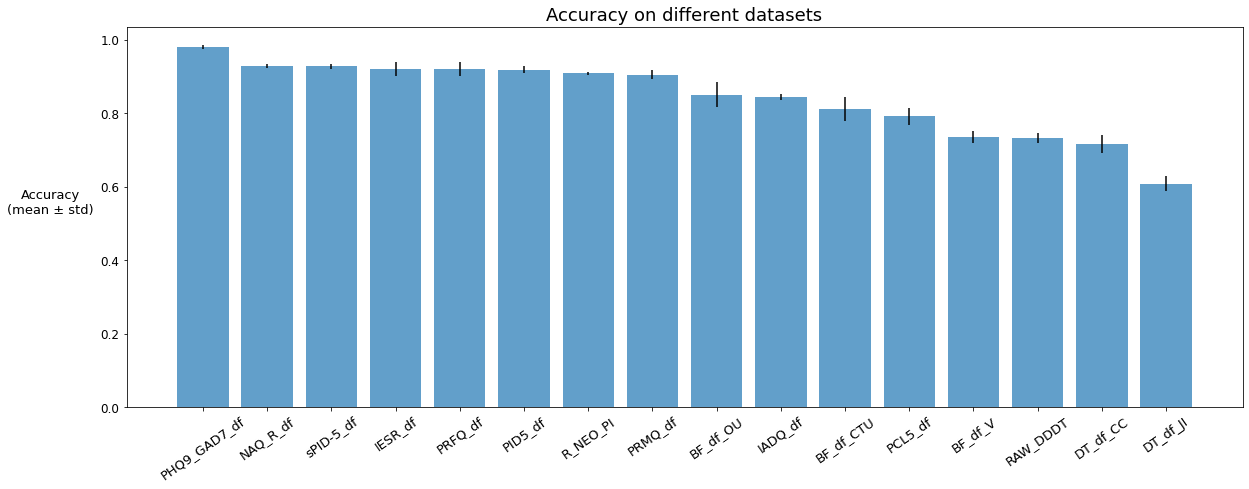

In [30]:
plt.figure(figsize = (20, 7))
plt.bar(x = summary.sort_values("Avg Acc. on selected features",
                                ascending = False)["Dataset name"],
        height = summary.sort_values("Avg Acc. on selected features",
                                     ascending = False)["Avg Acc. on selected features"],
        yerr = summary.sort_values("Avg Acc. on selected features",
                                   ascending = False)["Accuracy Std on selected features"], alpha = .7)
plt.xticks(rotation = 35, fontsize = 13)
plt.yticks(fontsize = 12)
plt.ylabel("Accuracy\n(mean ± std)", fontsize = 13, rotation = 0, labelpad = 50)
plt.title("Accuracy on different datasets", fontsize = 18)
plt.show()

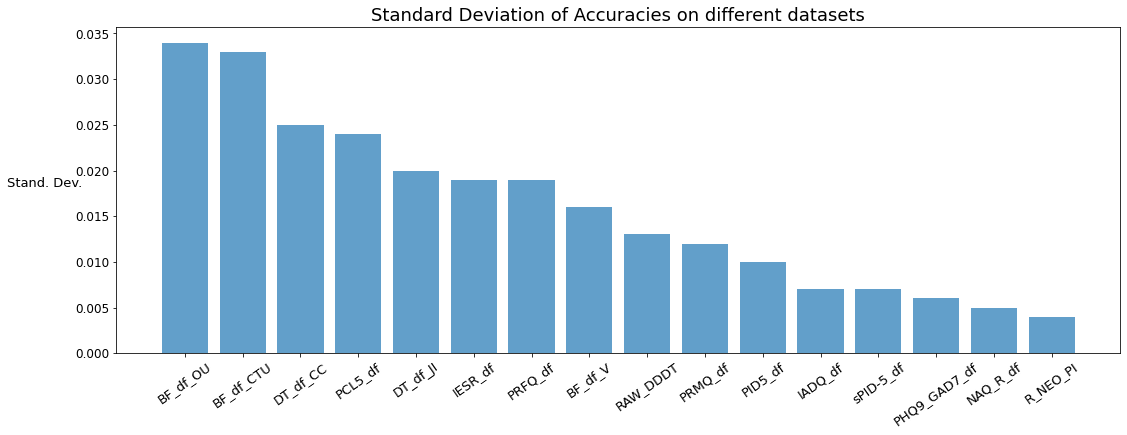

In [31]:
plt.figure(figsize = (18, 6))
plt.bar(x = summary.sort_values("Accuracy Std on selected features",
                                ascending = False)["Dataset name"],
        height = summary.sort_values("Accuracy Std on selected features",
                                     ascending = False)["Accuracy Std on selected features"], alpha = .7)
plt.xticks(rotation = 35, fontsize = 13)
plt.yticks(fontsize = 12)
plt.ylabel("Stand. Dev.", fontsize = 13, rotation = 0, labelpad = 30)
plt.title("Standard Deviation of Accuracies on different datasets", fontsize = 18)
plt.show()

---
---
---